# Opioid Addiction Project
## Notebook 05: Feature Importance

This notebook focuses on calculating feature importance

1. Load trained models from disk
2. Generate feature importance (Shapley values) ...
  * For the overall model
  * For individual predictions, including re-aggregating one-hot encoded values.

Generating feature importance (Shapley values) was originally also part of this notebook, but the long  execution time of model training and calibration made it more efficient to include in a new notebook.

### W210, Capstone
Summer 2019

Team:  Cameron Kennedy, Aditi Khullar, Rachel Kramer, Sharad Varadarajan

# 0. Load Libraries and Set Global Variables
This analysis is performed in the cells below.

In [1]:
#Import Required Libraries

#General libraries
import numpy as np
import pandas as pd
import joblib  #Used to save (pickle) models
from collections import defaultdict
import operator
import matplotlib.pyplot as plt
from scipy import stats

#Feature Importance
import shap #conda install -c conda-forge shap
shap.initjs()  #Javascript for Shapley Values

#Debugging / performance
from timeit import default_timer as timer

#Set initial parameter(s)
pd.set_option('display.max_rows', 100)
pd.options.display.max_columns = 200
dataDir = './data/'

# 1. Load Data

This step loads the models and data.

In [2]:
start = timer()

#Load Models
modelLR = joblib.load(dataDir+'modelLR.model')
calibratorLR = joblib.load(dataDir+'calibLR.model')

modelXGB = joblib.load(dataDir+'modelXGB.model')
calibratorXGB = joblib.load(dataDir+'calibXGB.model')


#Load data used for feature importance
#OLD, USING NUMPY NOW
#valX = pd.read_pickle(dataDir+'valX.pickle.zip')
#testX = pd.read_pickle(dataDir+'testX.pickle.zip')
valX = np.load(file=dataDir+'valX.npy')
testX = np.load(file=dataDir+'testX.npy')

#Load feature names (column names)
colNamesList = joblib.load(dataDir+'colNamesList.zip')

end = timer()
print('Run time: {:.1f} seconds'.format(end - start)) # Time in seconds

print(type(modelXGB))
print(type(calibratorXGB))
print(type(valX))
print(type(testX))

Run time: 0.1 seconds
<class 'xgboost.sklearn.XGBClassifier'>
<class 'sklearn.calibration.CalibratedClassifierCV'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [3]:
#Get stats
predProbsLRCal = calibratorLR.predict_proba(testX)[:,1]
print('33%, 50% (median), 67% quantiles:', np.quantile(predProbsLRCal, [1/4, 1/2, 3/4]))
print('Average Score:', np.mean(predProbsLRCal))
print('Percentile of Average Score:',stats.percentileofscore(predProbsLRCal, np.mean(predProbsLRCal)) / 100)

33%, 50% (median), 67% quantiles: [0.06896552 0.09090909 0.21134021]
Average Score: 0.16478701195342102
Percentile of Average Score: 0.7045227386306847


# 2. Feature Importance

This section calculates feature importance for the models, split into two items:

1. Calculate overall feature importance for the model. This will be useful for understanding the model as a whole, and in that sense is akin to EDA, but for the model rather than the raw data.
2. Calculate feature importance for an individual example. This is what will be used when giving individual respondents their score.

As part of these tasks, we will also incorporate aggregating feature importance scores from one-hot encoded features.

In [4]:
calibratorXGB.predict_proba(np.array(testX[[6]]))[0][1]

0.10117236524820328

In [5]:
#Make a single prediction
for row in range(0,50):
    predLR = modelLR.predict_proba(testX[[row]])[0][1]
    predLRCal = calibratorLR.predict_proba(testX[[row]])[0][1]
    
    predXGB = modelXGB.predict_proba(testX[[row]])[0][1]
    predXGBCal = calibratorXGB.predict_proba(testX[[row]])[0][1]
    
    #print('Case {}:  UNCALIBRATED LR Prediction: {:.2%}'.format(row, predLR))
    print('Case {}:    CALIBRATED LR Prediction: {:.2%}'.format(row, predLRCal))
    #print('Case {}: UNCALIBRATED XGB Prediction: {:.2%}'.format(row, predXGB))
    print('Case {}:   CALIBRATED XGB Prediction: {:.2%}\n'.format(row, predXGBCal))       

Case 0:    CALIBRATED LR Prediction: 53.38%
Case 0:   CALIBRATED XGB Prediction: 17.23%

Case 1:    CALIBRATED LR Prediction: 3.59%
Case 1:   CALIBRATED XGB Prediction: 15.39%

Case 2:    CALIBRATED LR Prediction: 47.76%
Case 2:   CALIBRATED XGB Prediction: 32.15%

Case 3:    CALIBRATED LR Prediction: 27.93%
Case 3:   CALIBRATED XGB Prediction: 25.82%

Case 4:    CALIBRATED LR Prediction: 21.13%
Case 4:   CALIBRATED XGB Prediction: 10.43%

Case 5:    CALIBRATED LR Prediction: 27.05%
Case 5:   CALIBRATED XGB Prediction: 12.20%

Case 6:    CALIBRATED LR Prediction: 27.05%
Case 6:   CALIBRATED XGB Prediction: 10.12%

Case 7:    CALIBRATED LR Prediction: 4.99%
Case 7:   CALIBRATED XGB Prediction: 10.44%

Case 8:    CALIBRATED LR Prediction: 47.76%
Case 8:   CALIBRATED XGB Prediction: 23.84%

Case 9:    CALIBRATED LR Prediction: 8.02%
Case 9:   CALIBRATED XGB Prediction: 21.47%

Case 10:    CALIBRATED LR Prediction: 3.59%
Case 10:   CALIBRATED XGB Prediction: 6.85%

Case 11:    CALIBRATED L

In [6]:
#Calculate Shapley Values
#NOTE: Currently this takes a couple minutes to run

#Create XGB Explainer
explainerXGB = shap.TreeExplainer(modelXGB, valX, feature_dependence='independent', model_output='probability')
#Note, very specifically this is where we need XGBoost 0.81 (0.80 failed, and 0.90 killed the kernel).

#Create LR Calibrated Explainer
valX_Kmeans = shap.kmeans(valX, 200)  #with 200 it takes ~1.2 sec to generate a prediction
explainerLRCal = shap.KernelExplainer(calibratorLR.predict_proba, valX_Kmeans)

#OLD WAY (slow because it uses all the background samples, using kmeans instead, above)
#explainerLRCal = shap.KernelExplainer(calibratorLR.predict_proba, valX)


#This helped at one point: https://evgenypogorelov.com/multiclass-xgb-shap.html

'''WARNING MESSAGE:
Using 13340 background data samples could cause slower run times. 
Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.
'''

Using 200 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


'WARNING MESSAGE:\nUsing 13340 background data samples could cause slower run times. \nConsider using shap.kmeans(data, K) to summarize the background as K weighted samples.\n'

In [7]:
#Save the explainer (for use in the web app)
joblib.dump(explainerXGB, dataDir+'modelXGB.explainer')
joblib.dump(explainerLRCal, dataDir+'modelLRCal.explainer')

['./data/modelLRCal.explainer']

In [8]:
#This cell takes ~3 min to run

#Overall model inspection
valXSample = valX[np.random.choice(valX.shape[0], 100, replace=False), :]
shap_valuesLRCal = explainerLRCal.shap_values(valXSample)
shap_valuesXGB = explainerXGB.shap_values(valXSample)

C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) t

C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) t

C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) t

C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) t

C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) t

C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) t

C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) t

C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) t

C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) t

 99%|===================| 99/100 [01:20<00:00]        

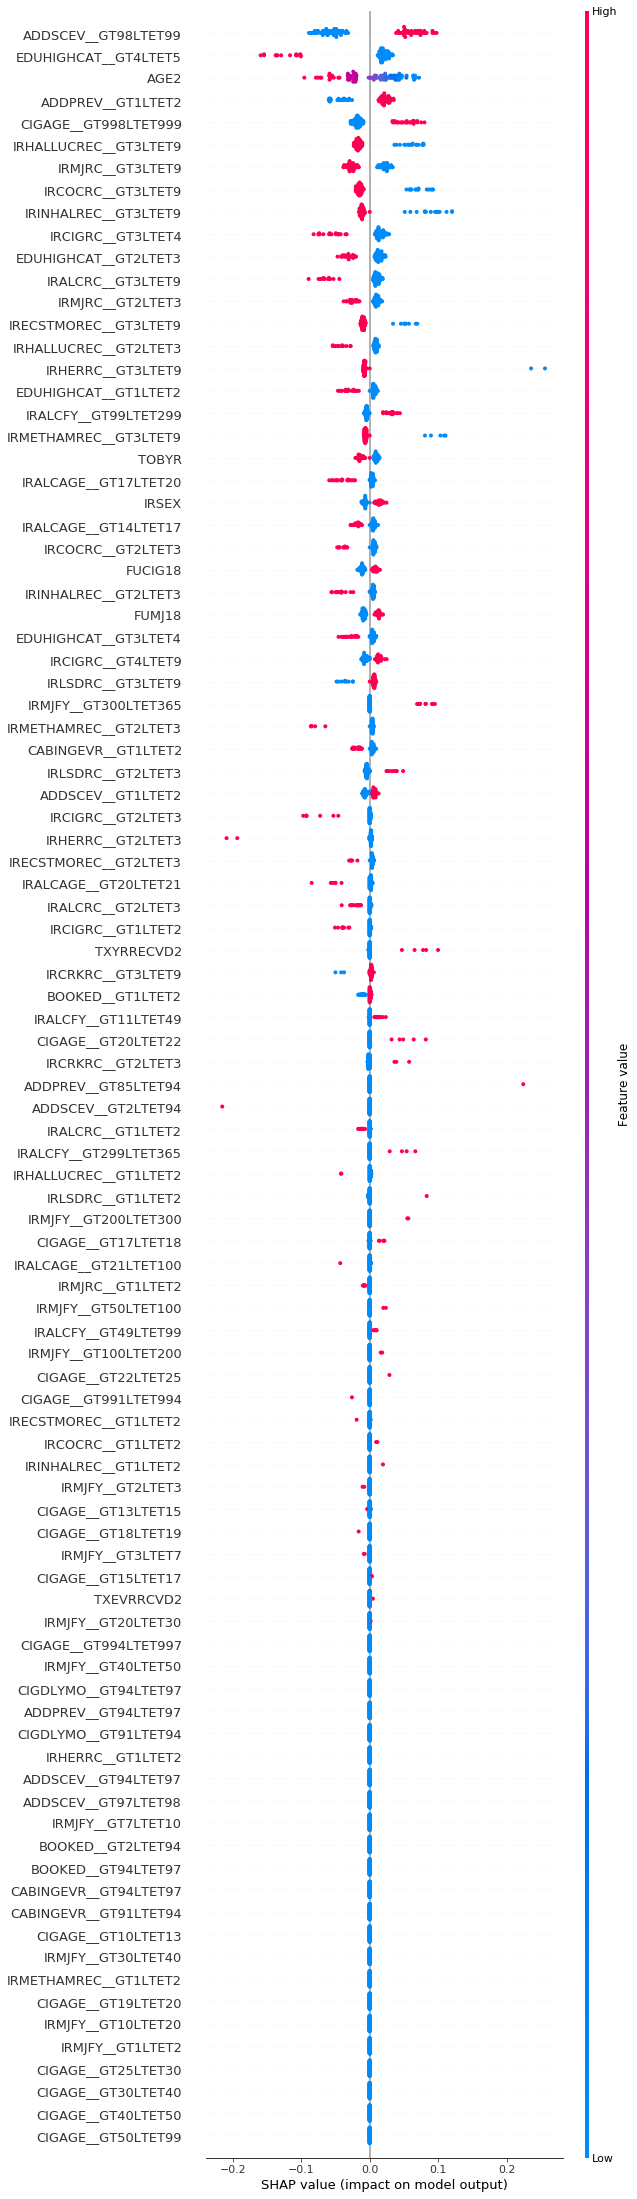

In [29]:
shap.summary_plot(np.array(shap_valuesLRCal)[1], valXSample, 
                  feature_names=colNamesList, max_display=-1, auto_size_plot=True)

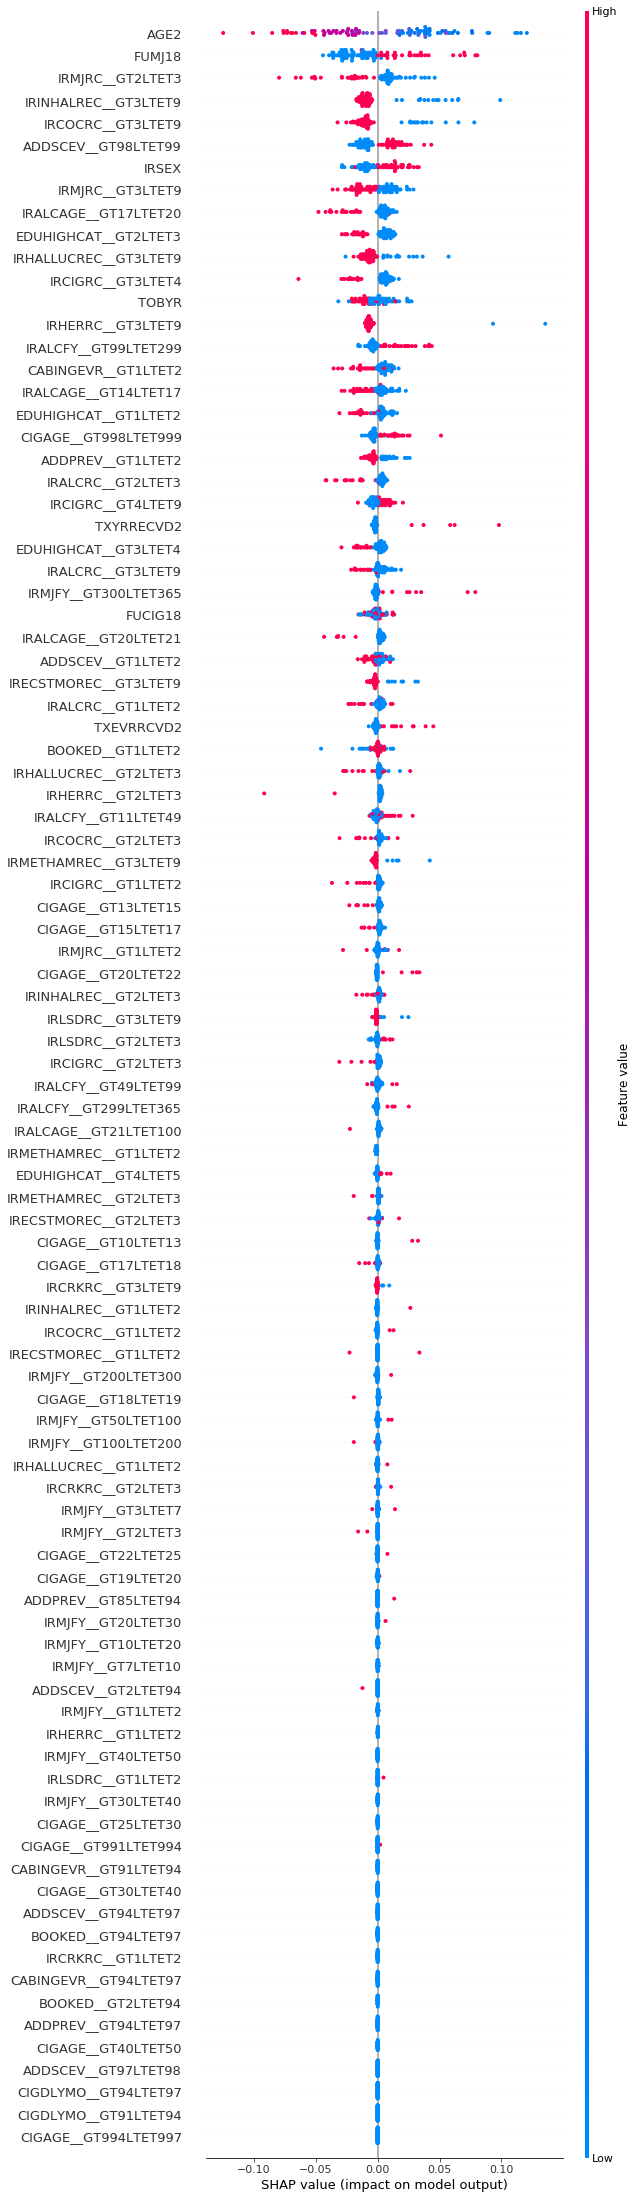

In [25]:
shap.summary_plot(shap_valuesXGB, valXSample, 
                  feature_names=colNamesList, max_display=-1)

In [11]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

testCaseID = 14

#print(shap_values)
print(shap_valuesXGB.shape)
print(shap_valuesXGB[testCaseID])

(100, 96)
[-0.006 -0.    -0.    -0.001  0.    -0.     0.    -0.009  0.055 -0.005
  0.     0.     0.006 -0.    -0.    -0.001  0.001  0.003 -0.     0.
  0.    -0.    -0.     0.    -0.    -0.     0.    -0.     0.     0.014
  0.     0.     0.005 -0.012 -0.002 -0.001 -0.013  0.039 -0.015  0.004
  0.002  0.002 -0.002 -0.002  0.     0.003  0.001  0.004  0.006 -0.037
  0.002  0.011 -0.005 -0.001  0.002 -0.022 -0.    -0.    -0.001  0.
 -0.007  0.019 -0.     0.005  0.005  0.     0.003 -0.009 -0.001  0.001
 -0.006 -0.     0.    -0.001 -0.001  0.001 -0.003  0.    -0.001  0.
 -0.    -0.001 -0.016 -0.002 -0.     0.    -0.     0.001 -0.     0.002
  0.017  0.015  0.019  0.    -0.001 -0.002]


In [12]:
#Notice here how with the LRCal shapley values, we have to take the [1] to get the same
#as the XGB shapley values
print(np.array(shap_valuesLRCal)[1].shape)
print(np.array(shap_valuesLRCal)[1][testCaseID])

(100, 96)
[ 0.028  0.     0.     0.009  0.     0.     0.    -0.08   0.037  0.002
  0.     0.     0.006  0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.064
  0.     0.     0.008 -0.04   0.007  0.026 -0.013  0.013 -0.021  0.005
  0.002  0.001  0.     0.     0.     0.033  0.     0.001  0.013 -0.051
  0.     0.019 -0.009  0.     0.008 -0.019  0.    -0.002  0.003  0.
 -0.028  0.051  0.001 -0.045  0.06   0.     0.002 -0.009  0.     0.007
 -0.014  0.    -0.006  0.008  0.     0.005 -0.008  0.     0.     0.
  0.     0.    -0.01   0.     0.     0.     0.     0.     0.     0.
  0.013  0.024  0.016 -0.015  0.    -0.002]


In [13]:
#A quick comparison of FUMJ18 and AGE2 for different models
for testCaseID in range(50,80):
    print('TEST CASE:', testCaseID)
    print('FUMJ18, XGB  ', shap_valuesXGB[testCaseID][47])
    print('FUMJ18, LRCal', np.array(shap_valuesLRCal)[1][testCaseID][47])
    print()
    print('AGE2, XGB  ', shap_valuesXGB[testCaseID][11])
    print('AGE2, LRCal', np.array(shap_valuesLRCal)[1][testCaseID][11])
    print()
    print()

TEST CASE: 50
FUMJ18, XGB   0.002006526061916456
FUMJ18, LRCal 0.0

AGE2, XGB   2.8151130640110943e-06
AGE2, LRCal 0.0


TEST CASE: 51
FUMJ18, XGB   0.002926384001143336
FUMJ18, LRCal 0.0

AGE2, XGB   4.292511510193886e-06
AGE2, LRCal 0.0


TEST CASE: 52
FUMJ18, XGB   0.0058208771653381
FUMJ18, LRCal 0.0

AGE2, XGB   2.719950097452024e-05
AGE2, LRCal 0.0


TEST CASE: 53
FUMJ18, XGB   0.003346276813562146
FUMJ18, LRCal 0.0014649869383047825

AGE2, XGB   2.373861691243943e-05
AGE2, LRCal 0.0


TEST CASE: 54
FUMJ18, XGB   0.0037111206942191015
FUMJ18, LRCal 0.0008269334339449535

AGE2, XGB   1.294381302998206e-05
AGE2, LRCal 0.0


TEST CASE: 55
FUMJ18, XGB   0.0015420259783347112
FUMJ18, LRCal 0.0

AGE2, XGB   -8.506753626867681e-08
AGE2, LRCal 0.0


TEST CASE: 56
FUMJ18, XGB   0.003714805882890862
FUMJ18, LRCal 0.0

AGE2, XGB   2.5854464778022418e-05
AGE2, LRCal 0.0


TEST CASE: 57
FUMJ18, XGB   -0.0017578923385193263
FUMJ18, LRCal -0.01351197491228634

AGE2, XGB   -5.894425186009312e-06

## Individual Predictions

Now that we have our overall model, we can build predictions at the individual level.

It's important that from here forward, we generate a new shapley value for each individual prediction (don't use the values from the sample).

In [14]:
#Make an individual prediction on test data

#Get a random row from our test data
randTestRow = testX[np.random.choice(testX.shape[0], 1, replace=False), :] #1 means 1 row

#Make the prediction from the model(s)
predM = modelXGB.predict_proba(randTestRow)[0][1]
predC = calibratorXGB.predict_proba(randTestRow)[0][1]
print('UNCALIBRATED Prediction: {:.2%}'.format(predM))
print('  CALIBRATED Prediction: {:.2%}\n'.format(predC))

UNCALIBRATED Prediction: 13.29%
  CALIBRATED Prediction: 10.34%



In [15]:
randTestRow

array([[1.   , 0.   , 0.   , 1.   , 0.   , 0.   , 0.   , 0.   , 0.462,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 1.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 1.   , 0.   , 0.   ,
        0.   , 1.   , 1.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        1.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 1.   , 0.   , 0.   , 1.   , 0.   , 0.   , 1.   , 0.   ,
        0.   , 1.   , 0.   , 0.   , 1.   , 0.   , 0.   , 1.   , 0.   ,
        0.   , 1.   , 0.   , 0.   , 1.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 1.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 1.   , 1.   , 1.   , 0.   ]])

In [16]:
start = timer()

#Generate shapley values from this row
shapVal = explainerLRCal.shap_values(randTestRow)

end = timer()
print('Run time: {:.0f} seconds'.format(end - start))

C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \



Run time: 1 seconds


In [17]:
#Plot shapley values
shap.force_plot(explainerLRCal.expected_value[1], shapVal[1], randTestRow, feature_names=colNamesList)

In the cell above, notice the prediction in the plot matches the uncalibrated prediction from the model.

In [18]:
#Get the baseline value (exepcted value)
expValLRCal = explainerLRCal.expected_value #This represents the AVERAGE (not the median) value
expValLRCal[1]

0.1707436418041542

In [19]:
#Matrix of individual shapley values for each feature
np.array(shapVal[0])

array([[-0.024,  0.   ,  0.   , -0.008,  0.   ,  0.   ,  0.   ,  0.065,
         0.029,  0.008,  0.   ,  0.   , -0.004,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.019,  0.   ,  0.   ,
        -0.008,  0.033, -0.005, -0.021,  0.011, -0.011,  0.017, -0.004,
        -0.002, -0.   ,  0.   ,  0.   ,  0.   , -0.03 , -0.001, -0.001,
        -0.011, -0.001,  0.   , -0.014,  0.006,  0.   , -0.007,  0.017,
         0.   ,  0.002, -0.002, -0.001, -0.004,  0.011, -0.001, -0.01 ,
         0.018,  0.   , -0.002,  0.008,  0.   , -0.005,  0.012,  0.001,
         0.005, -0.007,  0.   , -0.004,  0.007,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.025,  0.   ,
         0.   ,  0.   , -0.011, -0.02 , -0.013,  0.012,  0.   ,  0.   ]])

In [20]:
explainerXGB.shap_values(randTestRow)

array([[-0.002, -0.   , -0.   , -0.006,  0.   , -0.   ,  0.   , -0.011,
        -0.059, -0.   ,  0.   ,  0.   ,  0.004, -0.   , -0.   ,  0.   ,
         0.001,  0.001, -0.   ,  0.   , -0.015, -0.   , -0.   ,  0.   ,
        -0.   , -0.   ,  0.   , -0.   ,  0.   , -0.008,  0.   ,  0.   ,
         0.001, -0.012,  0.004, -0.   , -0.003,  0.025, -0.013,  0.002,
         0.002,  0.001,  0.001, -0.001, -0.002,  0.004,  0.002,  0.004,
         0.001,  0.001,  0.   ,  0.01 , -0.008, -0.   ,  0.001, -0.013,
         0.   ,  0.   , -0.001, -0.   , -0.002, -0.005, -0.001,  0.003,
        -0.013,  0.   ,  0.002, -0.008, -0.   ,  0.001, -0.009, -0.   ,
        -0.   , -0.002, -0.001,  0.001, -0.003, -0.   , -0.   ,  0.   ,
        -0.   , -0.   , -0.   , -0.002, -0.   , -0.   ,  0.006,  0.001,
        -0.   ,  0.001,  0.015,  0.012,  0.012, -0.004,  0.027, -0.004]])

In [21]:
#Aggregate shapley values for one-hot vectors

shapDict = defaultdict(list) #Handy: creates blank list if key doesn't exist, or appends to it if it does.

#Get everything before the '_' character of each column name
#Then create the column index numbers for those keys 
#These numbers correspond to the locations in the shapley output array
for i, colName in enumerate(colNamesList):
    shapDict[colName.split('_')[0]].append(i)
    
#Make a list of aggregated values shapley
print(shapDict)
print()
for k in shapDict: #Loop through every key in the dict
    shapSum = 0.0 #Reset to 0
    for index in shapDict[k]: #Loop through every item in the key's value (a list of column indexes)
        shapSum += np.array(shapVal[0])[0][index] #Add the value for each item
    shapDict[k] = shapSum #Replace the list with the aggregated shapley value (the sum of each individual value)
    
print(shapDict)

defaultdict(<class 'list'>, {'ADDPREV': [0, 1, 2], 'ADDSCEV': [3, 4, 5, 6, 7], 'AGE2': [8], 'BOOKED': [9, 10, 11], 'CABINGEVR': [12, 13, 14], 'CIGAGE': [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 'CIGDLYMO': [30, 31], 'EDUHIGHCAT': [32, 33, 34, 35], 'FUCIG18': [36], 'FUMJ18': [37], 'IRALCAGE': [38, 39, 40, 41], 'IRALCFY': [42, 43, 44, 45], 'IRALCRC': [46, 47, 48], 'IRCIGRC': [49, 50, 51, 52], 'IRCOCRC': [53, 54, 55], 'IRCRKRC': [56, 57, 58], 'IRECSTMOREC': [59, 60, 61], 'IRHALLUCREC': [62, 63, 64], 'IRHERRC': [65, 66, 67], 'IRINHALREC': [68, 69, 70], 'IRLSDRC': [71, 72, 73], 'IRMETHAMREC': [74, 75, 76], 'IRMJFY': [77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88], 'IRMJRC': [89, 90, 91], 'IRSEX': [92], 'TOBYR': [93], 'TXEVRRCVD2': [94], 'TXYRRECVD2': [95]})

defaultdict(<class 'list'>, {'ADDPREV': -0.02400983247625832, 'ADDSCEV': 0.05649570015395863, 'AGE2': 0.029310853377792587, 'BOOKED': 0.008050514917769962, 'CABINGEVR': -0.0036060162589853046, 'CIGAGE': 0.0190090399

## Summary

So for output, we need:

1. User's prediction, __%
2. Percentile (later, need distribution first, not hard)
3. +/-__._% (just print for now)



In [22]:
#Print Summary Results

#Get a random row from our test data
randTestRow = testX[np.random.choice(testX.shape[0], 1, replace=False), :] #1 means 1 row

#Make the prediction from the model(s)
predM = calibratorLR.predict_proba(randTestRow)[0][1]
print('Prediction: {:.1%}'.format(predM))

#Generate shapley values from this row
shapVal = explainerLRCal.shap_values(randTestRow)
print('shapVal[1]:\n', shapVal[1])

#Aggregate shapley values for one-hot vectors
shapDict = defaultdict(list) #Handy: creates blank list if key doesn't exist, or appends to it if it does.

#Get everything before the '_' character of each column name
#Then create the column index numbers for those keys 
#These numbers correspond to the locations in the shapley output array
for i, colName in enumerate(colNamesList):
    shapDict[colName.split('_')[0]].append(i)
    
#Make a list of aggregated shapley values
for k in shapDict: #Loop through every key in the dict
    shapSum = 0.0 #Reset to 0
    for index in shapDict[k]: #Loop through every item in the key's value (a list of column indexes)
        shapSum += shapVal[1][0][index] #Add the value for each item
    shapDict[k] = shapSum #Replace the list with the aggregated shapley value (the sum of each individual value)

sortedShapDict = dict(sorted(shapDict.items(), key=operator.itemgetter(1)))
print('Feature Importance:')
sortedShapDict

Prediction: 14.8%


C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \



shapVal[1]:
 [[-0.043  0.     0.    -0.006  0.     0.     0.     0.059 -0.077  0.002
   0.     0.     0.005  0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.054
   0.     0.     0.007 -0.035  0.006  0.022  0.008 -0.009 -0.019  0.004
   0.002  0.     0.     0.     0.     0.028  0.     0.001  0.011  0.
   0.002 -0.073 -0.007  0.    -0.035  0.059  0.    -0.002  0.002  0.
   0.004 -0.01   0.002  0.01  -0.019  0.     0.002 -0.008  0.     0.006
  -0.012 -0.001 -0.005  0.007  0.     0.004 -0.007  0.     0.009  0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.011  0.021 -0.008  0.011  0.     0.   ]]
Feature Importance:


{'IRCIGRC': -0.07831595845404349,
 'AGE2': -0.07694639854346774,
 'ADDPREV': -0.043090961276589027,
 'IRALCAGE': -0.01292971060728502,
 'FUMJ18': -0.009199365094413232,
 'IRSEX': -0.008270842551795516,
 'IRHALLUCREC': -0.007201222175547764,
 'IRINHALREC': -0.006856487877958853,
 'IRHERRC': -0.006337080047416701,
 'IRECSTMOREC': -0.005903160263818222,
 'IRMETHAMREC': -0.002650496624769339,
 'EDUHIGHCAT': -0.0005249075103430298,
 'IRCRKRC': -0.0001053364399992169,
 'CIGDLYMO': 0.0,
 'TXEVRRCVD2': 0.0,
 'TXYRRECVD2': 0.0,
 'IRLSDRC': 0.00027956788259165047,
 'BOOKED': 0.001588746876638656,
 'CABINGEVR': 0.004504801635310463,
 'FUCIG18': 0.008009843976013262,
 'IRMJFY': 0.009100801480696762,
 'TOBYR': 0.010813653958864688,
 'IRALCRC': 0.012021403211730909,
 'IRCOCRC': 0.02355287618854454,
 'IRALCFY': 0.027834405458210903,
 'IRMJRC': 0.0316517431597525,
 'ADDSCEV': 0.05285282212283621,
 'CIGAGE': 0.05350094410888526}

### Sample
Joe User's Report:

YOUR LIKELIHOOD OF MISUSE: 39%

YOUR PERCENTILE: 95%

TOP FACTORS CONTRIBUTING TO THIS SCORE:

_(imagine these bullets as a bar chart)_

* Weed < 18 = Yes: +6.6%
* Age = 17: +5.9%
* IRSM... = X: +4.8%
* ...


### Math Check

Here we're going to check our prediction by comparing it to the sum of the baseline value (expected value) plus the total of the Shapley values for all predictors.  This also helps build the intuition for Shapley values overall, and their additive nature.

In [23]:
#Summing the shapley values for this sample
#Output represents the distance from the baseline (expected value)
shapTotal = sum(shapVal[1][0])
                   
print('                     Baseline: {:.1%}'.format(expValLRCal[1]))
print('       Distance from Baseline: {:.1%}'.format(shapTotal))
print('               Predicted Risk: {:.1%}'.format(expValLRCal[1] + shapTotal))
print('Checked Risk (should be same): {:.1%}'.format(predM))

                     Baseline: 17.1%
       Distance from Baseline: -2.3%
               Predicted Risk: 14.8%
Checked Risk (should be same): 14.8%
